# core

> Fill in a module description here

In [49]:
# | default_exp lstm


In [50]:
# | hide
from nbdev.showdoc import *


In [51]:
# | export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import os
import math
import torch


In [52]:
num_workers = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers, device


(4, 'cuda')

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [53]:
data = np.load("../sample_data/nyc_taxi.npz")
for k in data.keys():
    print(k)


t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


In [54]:
data["t_unit"]  # 1 hour is 2 steps, 24hrs is 48 steps


array('30 min', dtype='<U6')

In [55]:
data["training"].shape


(5500,)

In [56]:
df = pd.DataFrame(data["training"], index=data["t_train"], columns=["value"])
df


,value
1,-0.647416
2,-1.048144
3,-1.330880
4,-1.560078
5,-1.683378
...,...
5496,0.650634
5497,0.769805
5498,0.614499
5499,0.474090


In [57]:
window_size = 48  # so that one window is one day

data = [
    {
        "subset": get_window(
            df.values,
            window_size=window_size,
            end_step=end_step,
            indices=list(df.index),
            return_indices=False,
        ),
        "end_step": end_step,
        "start_step": end_step - window_size,
    }
    for end_step in range(
        window_size, len(df), window_size
    )  # take steps every 48 so that we end up with non-overlapping sequences
]


In [58]:
# Number of datapoints
len(df) - (window_size * window_size)


3196

In [59]:
len(data)


114

Preseve 10% of the dataset from this for validation set.

In [60]:
val_data_idxs = np.random.choice(
    range(len(data)), size=int(0.1 * len(data)), replace=False
)
trn_data_idxs = [idx for idx in range(len(data)) if idx not in val_data_idxs]
len(val_data_idxs), len(trn_data_idxs)


(11, 103)

In [61]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score


In [62]:
val_data = [data[idx] for idx in val_data_idxs]
trn_data = [data[idx] for idx in trn_data_idxs]


Calculate stats over training data.

In [63]:
trn_data[0]["subset"].shape


(48, 1)

In [64]:
n_features = trn_data[0]["subset"].shape[1]  # - 1
n_features


1

In [65]:
means = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
stds = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
slice_from = n_features - 1
for i, _trn_data in enumerate(trn_data):
    means[i] = (np.mean(_trn_data["subset"][:, slice_from:], axis=0)).astype(np.float32)
    stds[i] = (np.var(_trn_data["subset"][:, slice_from:], axis=0) ** 0.5).astype(
        np.float32
    )
means = means.mean(0)
stds = stds.mean(0)

means, stds


(array([0.0057052]), array([0.97371307]))

only first feature is numeric, so remove mean and std from the rest.

In [66]:
# means[slice_from:] = 0
# stds[slice_from:] = 1
means, stds


(array([0.0057052]), array([0.97371307]))

In [67]:
# | export
from ts_vae_lstm.vae import VAE, Encoder, Decoder, StochasticSampler
from fastcore.xtras import noop


Take `k` embeddings and predict the next `k` embeddings.

In [68]:
vae_model = torch.load("../models/vae_500.pth", map_location="cpu")


In [69]:
len(trn_data)


103

In [70]:
np.concatenate([trn_data[_idx]["subset"][:, slice_from:] for _idx in range(0, 3)]).shape


(144, 1)

In [71]:
window_size, n_features


(48, 1)

In [72]:
list(range(0, 2))


[0, 1]

In [73]:
# | export


class TSLSTMDataset(Dataset):
    def __init__(
        self,
        data,
        vae_model,
        window_size=48,
        latent_dim=128,
        n_features=1,
        n_prev_windows=2,
        mean=0,
        std=1,
        emb_mean=0,
        emb_std=1,
    ):
        self.data = data
        self.vae_model = vae_model
        self.mean = mean
        self.std = std
        self.emb_mean = emb_mean
        self.emb_std = emb_std
        self.n_prev_windows = n_prev_windows
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.n_features = n_features

    def __getitem__(self, idx):
        # assuming normed dataset
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        # ignore the timestamp column
        n_prev_windows = self.n_prev_windows
        x_subset = np.concatenate(
            [
                self.data[_idx]["subset"][:, slice_from:]
                for _idx in range(idx, idx + n_prev_windows)
            ]
        )
        y_subset = self.data[idx + n_prev_windows + 1]["subset"][:, slice_from:]
        x = torch.as_tensor(self.standardize(x_subset, self.mean, self.std)).to(
            torch.float32
        )
        y = (
            torch.as_tensor(self.standardize(y_subset, self.mean, self.std))
            .unsqueeze(0)
            .to(torch.float32)
        )
        x_emb, y_emb = self.get_embeddings(x), self.get_embeddings(y)
        x_emb = self.standardize(x_emb, self.emb_mean, self.emb_std).to(torch.float32)
        y_emb = self.standardize(y_emb, self.emb_mean, self.emb_std).to(torch.float32)
        return x_emb, y_emb  # 20, 1

    def __len__(self):
        return len(self.data) - (
            self.n_prev_windows + 2
        )  # so that ValueError can be prevented

    def get_embeddings(self, x):
        actual_shape = x.shape[0]  # number of datapoints
        latent_dim = self.latent_dim
        window_size = self.window_size
        n_features = self.n_features
        n_windows = x.shape[0] // window_size
        n_windows = n_windows + 1 if n_windows == 0 else n_windows
        x = x.reshape(n_windows, window_size, -1) if n_windows > 1 else x
        emb_val = torch.zeros((n_windows, latent_dim, n_features))
        with torch.no_grad():
            for idx in range(n_windows):
                # print(x[idx].shape)
                z_mean, z_var = vae_model.encoder(
                    x[idx].unsqueeze(0)
                )  # unsqueeze for vae model
                emb_val[idx] = vae_model.latent_sampler(z_mean, z_var).permute(
                    1, 0
                )  # 1, 20 -> 20, 1
            # reshape
            emb_val = (
                emb_val.reshape(latent_dim * n_windows, -1)
                if n_windows > 1
                else emb_val[0]
            )
            return emb_val

    def standardize(self, x, m, s):
        return (x - m) / (s)


In [74]:
dset_trn = TSLSTMDataset(trn_data, vae_model=vae_model, mean=means, std=stds)
means_ = np.zeros((len(dset_trn), n_features))  # ((len(trn_data), 4))
stds_ = np.zeros((len(dset_trn), n_features))  # ((len(trn_data), 4))

for i in range(len(dset_trn)):
    # can also use y as it is a single window
    means_[i], stds_[i] = dset_trn[i][0].mean(), dset_trn[i][0].std()
emb_means, emb_stds = means_.mean(), stds_.mean()


In [75]:
emb_means, emb_stds, means, stds


(-0.006634446651195035,
 0.9989979995621575,
 array([0.0057052]),
 array([0.97371307]))

In [76]:
dset_trn = TSLSTMDataset(
    trn_data,
    vae_model=vae_model,
    mean=means,
    std=stds,
    emb_mean=emb_means,
    emb_std=emb_stds,
)

dset_val = TSLSTMDataset(
    val_data,
    vae_model=vae_model,
    mean=means,
    std=stds,
    emb_mean=emb_means,
    emb_std=emb_stds,
)  # use same stats from training data


In [77]:
x_emb, y_emb = dset_trn[0]


In [78]:
x_emb.shape, y_emb.shape, y_emb.device


(torch.Size([256, 1]), torch.Size([128, 1]), device(type='cpu'))

In [79]:
len(dset_trn), len(dset_val)


(99, 7)

In [80]:
batch_size = 4


In [81]:
dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=num_workers,
)


In [82]:
xs, ys = next(iter(dl_trn))


In [83]:
xs.shape


torch.Size([4, 256, 1])

In [91]:
import random


In [95]:
class LSTM(nn.Module):
    def __init__(
        self,
        input_size=256,
        output_size=128,  # horizon into the future
        n_channels=1,
        hidden_size=512,
        num_layers=2,
        act=F.tanh,
        dropout_p=0.1,
        scale=1,
        tfr=0.5,
    ):
        super().__init__()
        # self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.LSTM
        self.scale = scale
        # self.linear_emb = nn.Linear(input_size, hidden_size, bias=False)
        self.encoder = self.rnn(
            input_size=input_size,
            hidden_size=hidden_size,
            dropout=dropout_p,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )
        hidden_size_d = hidden_size * 1  # if bidirectional=True, need twice
        self.decoder = self.rnn(
            input_size=output_size,
            hidden_size=hidden_size_d,
            dropout=dropout_p,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.tfr = tfr

        self.fc = nn.Linear(in_features=hidden_size_d * 1, out_features=output_size)

        self.act = act
        self.input_size = input_size
        # self.seq_len = seq_len
        self.hidden_size = hidden_size
        # self.hidden_size_d = hidden_size_d
        self.output_size = output_size

    def forward(self, x, y):
        # print(x.shape, y.shape)
        bs = x.shape[0]
        device = x.device
        output_size = y.shape[1]
        x = x.permute(0, 2, 1)  #  bs, 256, 1  -> bs, 1, 256
        y = y.permute(0, 2, 1)  #  bs, 128, 1  -> bs, 1, 128
        y_pred = torch.zeros_like(y, device=device)
        x_enc, (h_enc, c_enc) = self.encoder(x)  # bs, 1, 256 -> bs, 1, 512*2
        # set decoder hidden state as encoders hidden state from the last RNN layer
        h_dec = h_enc  # torch.concat([h_enc, h_enc], dim=2)  # num_layers, bs, 512
        c_dec = c_enc  # .concat([c_enc, c_enc], dim=2)  # num_layers, bs, 512
        # print(x_enc.shape, h_dec.shape)
        teacher_force = random.random() < self.tfr
        if teacher_force:
            decoder_inp = y
        else:
            decoder_inp = x[:, :, -output_size:]  # torch.concat([y], dim=2)
        # print(decoder_inp.shape)

        out, (h_dec, c_dec) = self.decoder(decoder_inp, (h_dec, c_dec))
        y_pred = self.act(self.fc(out))

        return y_pred.permute(0, 2, 1) * self.scale  #  # outputs_lin.   # bs, 256, 1


In [96]:
pred_ys = LSTM(input_size=256, output_size=128, hidden_size=512, scale=1)(xs, ys)
pred_ys.shape


torch.Size([4, 128, 1])

In [97]:
pred_ys.max() * 10, pred_ys.min()


(tensor(0.6501, grad_fn=<MulBackward0>),
 tensor(-0.0713, grad_fn=<MinBackward1>))

# Training loop

In [98]:
def get_sim_matrix(x):
    x = x / x.norm(dim=1, keepdim=True)
    return x @ x.T


In [99]:
F.huber_loss


<function torch.nn.functional.huber_loss(input: torch.Tensor, target: torch.Tensor, reduction: str = 'mean', delta: float = 1.0) -> torch.Tensor>

In [100]:
# | export


def loss_func_lstm(inputs, targets):
    bs = inputs.shape[0]
    distance = torch.norm(targets - inputs, dim=2)
    loss = torch.where(distance > 1, distance.pow(2), torch.clamp(1 - distance, min=0))
    return loss.sum((-1)).mean()
    # return loss


def huber_loss(inputs, targets):
    bs = inputs.shape[0]
    loss = F.huber_loss(inputs, targets, reduction="mean", delta=3)
    return loss  # sum((-1, -2)).mean()
    # return loss


def mean_absolute_error(predictions, targets):
    error = torch.abs(predictions - targets)
    mae = torch.sum(error, dim=(-1, -2))
    return torch.mean(mae)


def calculate_smape(predicted, actual):
    absolute_percentage_errors = torch.abs(predicted - actual) / (
        torch.abs(predicted) + torch.abs(actual)
    )
    return absolute_percentage_errors.sum((-1, -2)).mean()


def scorer_lstm(inputs, targets):
    with torch.no_grad():
        return torch.pow(inputs.squeeze() - targets.squeeze(), 2).mean()


In [101]:
loss_func_lstm(pred_ys, ys), scorer_lstm(pred_ys, ys), calculate_smape(
    pred_ys, ys
), mean_absolute_error(pred_ys, ys), huber_loss(pred_ys, ys)


(tensor(136.0246, grad_fn=<MeanBackward0>),
 tensor(0.8509),
 tensor(118.7797, grad_fn=<MeanBackward0>),
 tensor(94.5650, grad_fn=<MeanBackward0>),
 tensor(0.4254, grad_fn=<HuberLossBackward0>))

In [102]:
a = torch.tensor([[1.0, 2], [3.0, 4], [5.0, 6]]).unsqueeze(-1)
b = torch.tensor([[3.0, 4], [5.0, 6], [7.0, 8]]).unsqueeze(-1)
a.shape, b.shape


(torch.Size([3, 2, 1]), torch.Size([3, 2, 1]))

In [103]:
# | export
from fastcore.xtras import partial


In [104]:
def scaled_func(func, scale=1, *args, **kwargs):
    def mod_func(*args, **kwargs):
        result = func(*args, **kwargs)
        return result * scale

    return mod_func


In [105]:
from fastcore.xtras import noop


Epoch [1/200], Batch [24/24], Trn Loss: 103.102224, Trn Score: 1.016014, Val Loss: 101.574783, Val Score: 1.021585
Epoch [2/200], Batch [24/24], Trn Loss: 101.281685, Trn Score: 0.985682, Val Loss: 101.549530, Val Score: 0.989552
Epoch [3/200], Batch [24/24], Trn Loss: 100.609042, Trn Score: 0.973912, Val Loss: 102.566498, Val Score: 0.984617
Epoch [4/200], Batch [24/24], Trn Loss: 101.621360, Trn Score: 0.992839, Val Loss: 98.345139, Val Score: 0.962896
Epoch [5/200], Batch [24/24], Trn Loss: 101.821189, Trn Score: 0.992726, Val Loss: 105.098869, Val Score: 1.088862
Epoch [6/200], Batch [24/24], Trn Loss: 99.396475, Trn Score: 0.952969, Val Loss: 99.632339, Val Score: 0.959124
Epoch [7/200], Batch [24/24], Trn Loss: 100.481348, Trn Score: 0.982536, Val Loss: 104.602371, Val Score: 1.051034
Epoch [8/200], Batch [24/24], Trn Loss: 100.724464, Trn Score: 0.981418, Val Loss: 101.630119, Val Score: 1.017086
Epoch [9/200], Batch [24/24], Trn Loss: 100.856057, Trn Score: 0.985738, Val Loss: 

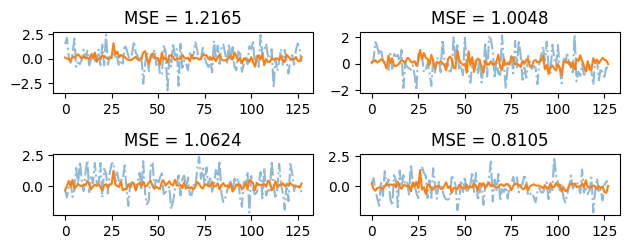

Epoch [20/200], Batch [24/24], Trn Loss: 98.505301, Trn Score: 0.943125, Val Loss: 102.567039, Val Score: 1.023538
Epoch [21/200], Batch [24/24], Trn Loss: 95.821314, Trn Score: 0.885417, Val Loss: 101.039101, Val Score: 0.964429
Epoch [22/200], Batch [24/24], Trn Loss: 97.709759, Trn Score: 0.930769, Val Loss: 102.290840, Val Score: 1.034594
Epoch [23/200], Batch [24/24], Trn Loss: 96.806023, Trn Score: 0.900152, Val Loss: 104.200409, Val Score: 1.066069
Epoch [24/200], Batch [24/24], Trn Loss: 96.826996, Trn Score: 0.907899, Val Loss: 100.306442, Val Score: 1.022868
Epoch 00024: reducing learning rate of group 0 to 9.0000e-04.
Epoch [25/200], Batch [24/24], Trn Loss: 97.289476, Trn Score: 0.916391, Val Loss: 93.901169, Val Score: 0.803792
Epoch [26/200], Batch [24/24], Trn Loss: 99.054409, Trn Score: 0.953665, Val Loss: 89.759171, Val Score: 0.816261
Epoch [27/200], Batch [24/24], Trn Loss: 99.222314, Trn Score: 0.954922, Val Loss: 89.553101, Val Score: 0.755227
Epoch [28/200], Batch

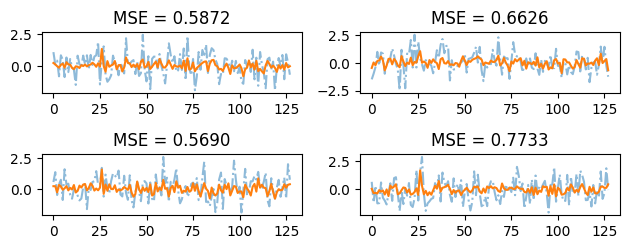

Epoch [40/200], Batch [24/24], Trn Loss: 94.295849, Trn Score: 0.867369, Val Loss: 82.876465, Val Score: 0.648019
Epoch [41/200], Batch [24/24], Trn Loss: 93.303751, Trn Score: 0.849249, Val Loss: 111.162796, Val Score: 1.199507
Epoch [42/200], Batch [24/24], Trn Loss: 92.298903, Trn Score: 0.826976, Val Loss: 86.469620, Val Score: 0.761602
Epoch [43/200], Batch [24/24], Trn Loss: 96.581369, Trn Score: 0.917405, Val Loss: 112.390533, Val Score: 1.250309
Epoch [44/200], Batch [24/24], Trn Loss: 96.894313, Trn Score: 0.919038, Val Loss: 112.283203, Val Score: 1.163757
Epoch [45/200], Batch [24/24], Trn Loss: 97.948686, Trn Score: 0.937198, Val Loss: 81.594460, Val Score: 0.656670
Epoch [46/200], Batch [24/24], Trn Loss: 94.820857, Trn Score: 0.874962, Val Loss: 109.935524, Val Score: 1.133596
Epoch [47/200], Batch [24/24], Trn Loss: 94.719621, Trn Score: 0.888514, Val Loss: 108.534340, Val Score: 1.169801
Epoch [48/200], Batch [24/24], Trn Loss: 97.169774, Trn Score: 0.914783, Val Loss: 

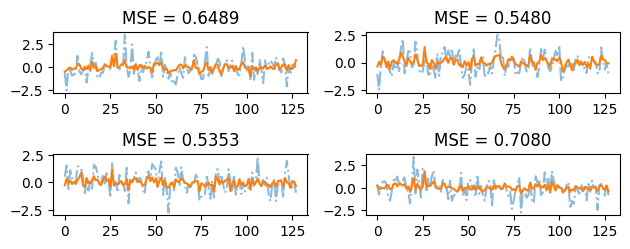

Epoch [60/200], Batch [24/24], Trn Loss: 94.318812, Trn Score: 0.875210, Val Loss: 77.613663, Val Score: 0.610045
Epoch [61/200], Batch [24/24], Trn Loss: 95.908811, Trn Score: 0.901479, Val Loss: 104.623764, Val Score: 1.038742
Epoch [62/200], Batch [24/24], Trn Loss: 89.800767, Trn Score: 0.797646, Val Loss: 105.992088, Val Score: 1.081632
Epoch [63/200], Batch [24/24], Trn Loss: 96.516922, Trn Score: 0.913752, Val Loss: 81.564529, Val Score: 0.606519
Epoch [64/200], Batch [24/24], Trn Loss: 88.966056, Trn Score: 0.782739, Val Loss: 79.754700, Val Score: 0.615555
Epoch [65/200], Batch [24/24], Trn Loss: 95.074179, Trn Score: 0.891442, Val Loss: 74.486679, Val Score: 0.552060
Epoch [66/200], Batch [24/24], Trn Loss: 94.923468, Trn Score: 0.890737, Val Loss: 79.180634, Val Score: 0.609262
Epoch [67/200], Batch [24/24], Trn Loss: 93.732361, Trn Score: 0.866895, Val Loss: 85.114105, Val Score: 0.669939
Epoch [68/200], Batch [24/24], Trn Loss: 96.214488, Trn Score: 0.914621, Val Loss: 107

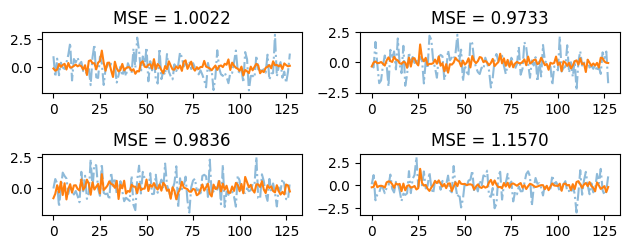

Epoch [80/200], Batch [24/24], Trn Loss: 95.865257, Trn Score: 0.905902, Val Loss: 100.625046, Val Score: 1.029004
Epoch [81/200], Batch [24/24], Trn Loss: 93.877359, Trn Score: 0.864757, Val Loss: 77.411324, Val Score: 0.598866
Epoch 00081: reducing learning rate of group 0 to 8.1000e-04.
Epoch [82/200], Batch [24/24], Trn Loss: 90.242869, Trn Score: 0.811103, Val Loss: 104.050285, Val Score: 1.059536
Epoch [83/200], Batch [24/24], Trn Loss: 91.942363, Trn Score: 0.843850, Val Loss: 78.384369, Val Score: 0.603103
Epoch [84/200], Batch [24/24], Trn Loss: 86.772898, Trn Score: 0.745042, Val Loss: 112.869675, Val Score: 1.220926
Epoch [85/200], Batch [24/24], Trn Loss: 92.170681, Trn Score: 0.849741, Val Loss: 68.198502, Val Score: 0.441385
Epoch [86/200], Batch [24/24], Trn Loss: 91.718466, Trn Score: 0.849150, Val Loss: 103.521866, Val Score: 1.105018
Epoch [87/200], Batch [24/24], Trn Loss: 88.148735, Trn Score: 0.777021, Val Loss: 73.390656, Val Score: 0.514507
Epoch [88/200], Batch 

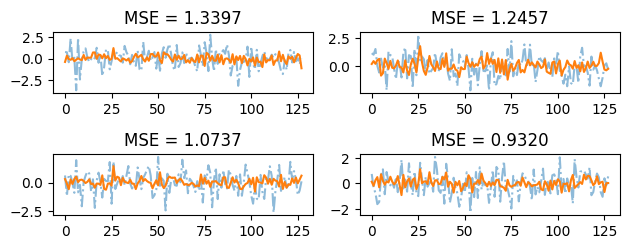

Epoch [100/200], Batch [24/24], Trn Loss: 94.167028, Trn Score: 0.887585, Val Loss: 108.795853, Val Score: 1.147786
Epoch [101/200], Batch [24/24], Trn Loss: 96.567350, Trn Score: 0.923596, Val Loss: 107.484360, Val Score: 1.123131
Epoch [102/200], Batch [24/24], Trn Loss: 88.107185, Trn Score: 0.779154, Val Loss: 78.792847, Val Score: 0.599145
Epoch [103/200], Batch [24/24], Trn Loss: 97.196056, Trn Score: 0.942763, Val Loss: 105.748260, Val Score: 1.067978
Epoch [104/200], Batch [24/24], Trn Loss: 91.446496, Trn Score: 0.839349, Val Loss: 103.817398, Val Score: 1.085411
Epoch [105/200], Batch [24/24], Trn Loss: 94.600118, Trn Score: 0.888062, Val Loss: 73.292297, Val Score: 0.526825
Epoch [106/200], Batch [24/24], Trn Loss: 94.285167, Trn Score: 0.884266, Val Loss: 109.514748, Val Score: 1.122990
Epoch [107/200], Batch [24/24], Trn Loss: 89.628788, Trn Score: 0.803353, Val Loss: 114.252235, Val Score: 1.223331
Epoch 00107: reducing learning rate of group 0 to 6.5610e-04.
Epoch [108/2

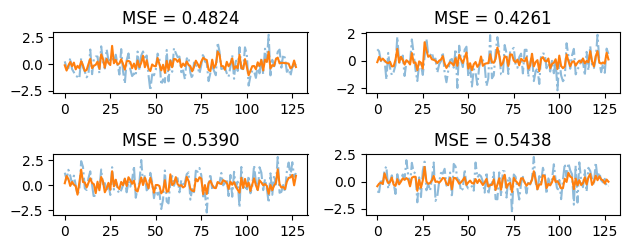

Epoch [120/200], Batch [24/24], Trn Loss: 94.826362, Trn Score: 0.900296, Val Loss: 74.324524, Val Score: 0.497831
Epoch [121/200], Batch [24/24], Trn Loss: 86.419970, Trn Score: 0.755771, Val Loss: 114.391327, Val Score: 1.258325
Epoch [122/200], Batch [24/24], Trn Loss: 88.092891, Trn Score: 0.800153, Val Loss: 70.413818, Val Score: 0.474694
Epoch 00122: reducing learning rate of group 0 to 5.9049e-04.
Epoch [123/200], Batch [24/24], Trn Loss: 86.825610, Trn Score: 0.778465, Val Loss: 68.200790, Val Score: 0.458417
Epoch [124/200], Batch [24/24], Trn Loss: 95.678756, Trn Score: 0.924215, Val Loss: 60.343479, Val Score: 0.348469
Epoch [125/200], Batch [24/24], Trn Loss: 87.538557, Trn Score: 0.782130, Val Loss: 61.884018, Val Score: 0.365244
Epoch [126/200], Batch [24/24], Trn Loss: 84.718060, Trn Score: 0.732440, Val Loss: 121.307785, Val Score: 1.350073
Epoch [127/200], Batch [24/24], Trn Loss: 87.402558, Trn Score: 0.789823, Val Loss: 110.196930, Val Score: 1.219298
Epoch [128/200]

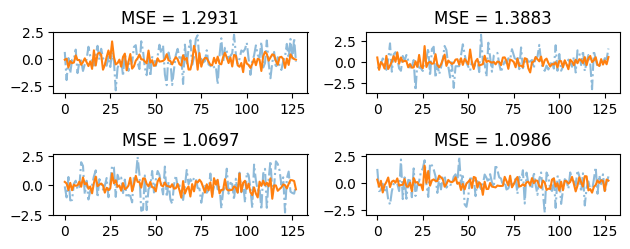

Epoch [140/200], Batch [24/24], Trn Loss: 71.101903, Trn Score: 0.528550, Val Loss: 111.357727, Val Score: 1.212411
Epoch [141/200], Batch [24/24], Trn Loss: 86.328797, Trn Score: 0.799801, Val Loss: 119.634514, Val Score: 1.344131
Epoch [142/200], Batch [24/24], Trn Loss: 92.506723, Trn Score: 0.878894, Val Loss: 111.819656, Val Score: 1.267320
Epoch [143/200], Batch [24/24], Trn Loss: 79.153507, Trn Score: 0.664159, Val Loss: 105.666397, Val Score: 1.140337
Epoch [144/200], Batch [24/24], Trn Loss: 89.541502, Trn Score: 0.843718, Val Loss: 58.089676, Val Score: 0.327352
Epoch [145/200], Batch [24/24], Trn Loss: 91.264194, Trn Score: 0.867413, Val Loss: 111.570404, Val Score: 1.183133
Epoch 00145: reducing learning rate of group 0 to 5.3144e-04.
Epoch [146/200], Batch [24/24], Trn Loss: 82.078101, Trn Score: 0.713075, Val Loss: 112.272224, Val Score: 1.166840
Epoch [147/200], Batch [24/24], Trn Loss: 84.245286, Trn Score: 0.739641, Val Loss: 55.319000, Val Score: 0.307538
Epoch [148/2

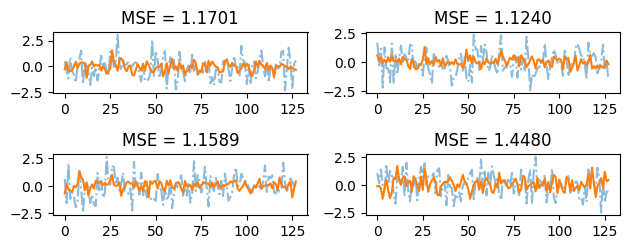

Epoch [160/200], Batch [24/24], Trn Loss: 88.640861, Trn Score: 0.819951, Val Loss: 111.707855, Val Score: 1.225250
Epoch [161/200], Batch [24/24], Trn Loss: 76.312470, Trn Score: 0.623890, Val Loss: 58.757050, Val Score: 0.323751
Epoch [162/200], Batch [24/24], Trn Loss: 75.717637, Trn Score: 0.617418, Val Loss: 106.535934, Val Score: 1.114181
Epoch [163/200], Batch [24/24], Trn Loss: 80.206624, Trn Score: 0.717642, Val Loss: 119.488808, Val Score: 1.380300
Epoch [164/200], Batch [24/24], Trn Loss: 88.697472, Trn Score: 0.831057, Val Loss: 60.722672, Val Score: 0.348423
Epoch [165/200], Batch [24/24], Trn Loss: 88.115205, Trn Score: 0.826725, Val Loss: 112.822418, Val Score: 1.255474
Epoch [166/200], Batch [24/24], Trn Loss: 95.879240, Trn Score: 0.936920, Val Loss: 105.474945, Val Score: 1.060737
Epoch [167/200], Batch [24/24], Trn Loss: 77.795487, Trn Score: 0.633682, Val Loss: 109.674622, Val Score: 1.178726
Epoch 00167: reducing learning rate of group 0 to 4.3047e-04.
Epoch [168/2

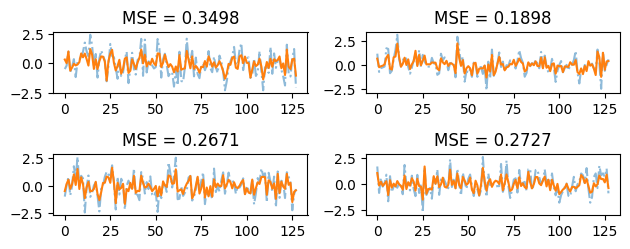

Epoch [180/200], Batch [24/24], Trn Loss: 81.796552, Trn Score: 0.727394, Val Loss: 53.570961, Val Score: 0.269858
Epoch [181/200], Batch [24/24], Trn Loss: 83.831682, Trn Score: 0.760602, Val Loss: 104.076027, Val Score: 1.046700
Epoch [182/200], Batch [24/24], Trn Loss: 77.773147, Trn Score: 0.654266, Val Loss: 47.881950, Val Score: 0.215640
Epoch [183/200], Batch [24/24], Trn Loss: 79.737364, Trn Score: 0.700406, Val Loss: 110.122971, Val Score: 1.191789
Epoch [184/200], Batch [24/24], Trn Loss: 77.242096, Trn Score: 0.655261, Val Loss: 120.435219, Val Score: 1.376175
Epoch [185/200], Batch [24/24], Trn Loss: 77.767783, Trn Score: 0.661831, Val Loss: 46.769920, Val Score: 0.220080
Epoch 00185: reducing learning rate of group 0 to 3.8742e-04.
Epoch [186/200], Batch [24/24], Trn Loss: 81.923064, Trn Score: 0.735606, Val Loss: 46.666687, Val Score: 0.208344
Epoch [187/200], Batch [24/24], Trn Loss: 90.980057, Trn Score: 0.859667, Val Loss: 105.554688, Val Score: 1.069149
Epoch [188/200

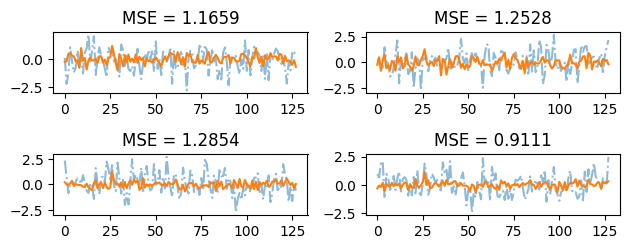

Epoch [200/200], Batch [24/24], Trn Loss: 94.201977, Trn Score: 0.916431, Val Loss: 109.742340, Val Score: 1.153780


In [106]:
train_dataloader = dl_trn
valid_dataloader = dl_val
num_epochs = 200
latent_dim = 128
hidden_size = 512
dropout_p = 0.2
num_layers = 2
tfr = 0.5
scale = 1
activation = noop  # partial(F.hardtanh, min_val=-5, max_val=5)

model = LSTM(
    input_size=latent_dim * 2,
    output_size=latent_dim,
    hidden_size=hidden_size,
    act=activation,
    dropout_p=dropout_p,
    num_layers=num_layers,
    tfr=tfr,
    scale=scale,
).to(device)

learning_rate = 1e-3
criterion = mean_absolute_error
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-6,
    # momentum=0.999,
    # nesterov=True,
)
scorer = scorer_lstm
# Training loop

print_every = len(train_dataloader)

# Define LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.9,
    patience=10,
    min_lr=1e-8,
    verbose=True,
)


# validation
def validate_epoch(dls, criterion, scorer, show=False):
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    with torch.no_grad():
        for batch_idx, (xs, ys) in enumerate(dls):
            # move to device
            xs = xs.to(device)
            ys = ys.to(device)

            # Forward pass
            pred_ys = model(xs, ys)

            loss = criterion(pred_ys, ys)
            # calc score
            score = scorer(pred_ys, ys)

            running_loss += loss.item()
            running_score += score.item()
        if show:
            for idx in range(batch_size):
                ax = plt.subplot(4, 2, idx + 1)
                # idx_feature = 0
                pred_current_example, current_points = (
                    pred_ys[idx].detach().cpu().squeeze(),
                    ys[idx].detach().cpu().squeeze(),
                )
                sns.lineplot(current_points.numpy(), alpha=0.5, linestyle="-.")
                sns.lineplot(pred_current_example.numpy())
                mse_val = F.mse_loss(pred_current_example, current_points)
                plt.title(f"MSE = {mse_val:.4f}")
            plt.tight_layout()
            plt.show()

    return running_loss, running_score


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    for batch_idx, (xs, ys) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        # move to device
        xs = xs.to(device)
        ys = ys.to(device)

        # Forward pass
        pred_ys = model(xs, ys)

        loss = criterion(pred_ys, ys)
        # calc score
        score = scorer(pred_ys, ys)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += score.item()
        if (batch_idx + 1) % print_every == 0:
            val_loss, val_score = validate_epoch(
                valid_dataloader, criterion, scorer, show=(epoch + 1) % 20 == 0
            )
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Trn Loss: {(running_loss / print_every):.6f}, Trn Score: {(running_score / print_every):.6f}, Val Loss: {(val_loss/len(valid_dataloader)):.6f}, Val Score: {(val_score/len(valid_dataloader)):.6f}"
            )
            running_loss = 0.0
            running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss)  # min the running_loss


In [50]:
torch.save(model, f"../models/lstm_{num_epochs}.pth")
f"../models/lstm_{num_epochs}.pth"


'../models/lstm_200.pth'

# Inference

In [107]:
with torch.no_grad():
    model.eval()
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device), ys_val.to(device))


In [108]:
pred_ys_val[0].shape


torch.Size([128, 1])

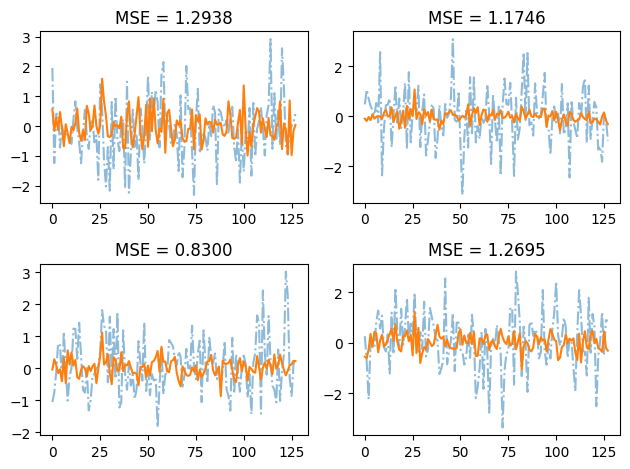

In [109]:
for idx in range(batch_size):
    ax = plt.subplot(2, 2, idx + 1)
    # idx_feature = 0
    pred_current_example, current_points, prev_points = (
        pred_ys[idx].detach().cpu().squeeze(),
        ys_val[idx].detach().cpu().squeeze(),
        xs_val[idx].detach().cpu().squeeze(),
    )
    # sns.lineplot(prev_points.numpy(), alpha=0.5, label="prev true")
    sns.lineplot(
        current_points.numpy(), alpha=0.5, linestyle="-."
    )  # , label="next true")
    sns.lineplot(pred_current_example.numpy())  # , label="next pred")
    mse_val = F.mse_loss(pred_current_example, current_points)
    # plt.ylim(-2, 2)
    plt.title(f"MSE = {mse_val:.4f}")
plt.tight_layout()


use a squared term if the absolute element-wise error falls below delta and a delta-scaled L1 term otherwise.

In [110]:
(pred_current_example - current_points).mean()


tensor(-0.0738)

# Reconstruct the time series 
Take the predicted embedding, pass it to the decoder of VAE to make the prediction.

In [111]:
pred_current_example.shape, current_points.shape


(torch.Size([128]), torch.Size([128]))

In [112]:
pred_ts_values = vae_model.decoder(pred_current_example.unsqueeze(0))
pred_ts_values_true = vae_model.decoder(current_points.unsqueeze(0))


In [113]:
pred_ts_values.shape


torch.Size([1, 48, 1])

In [114]:
F.mse_loss(pred_ts_values, pred_ts_values_true)


tensor(0.1932, grad_fn=<MseLossBackward0>)

Plot time series values decoded from embedding

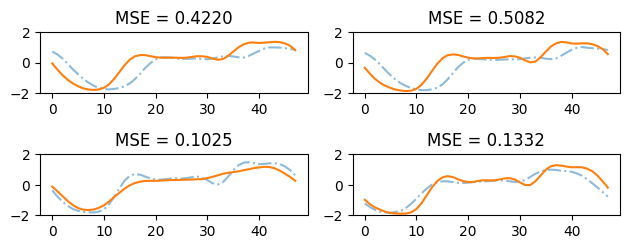

In [115]:
with torch.no_grad():
    xs_val, ys_val = next(iter(valid_dataloader))
    pred_ys_val = model(xs_val.to(device), ys_val.to(device))

for idx in range(batch_size):
    ax = plt.subplot(4, 2, idx + 1)
    # idx_feature = 0
    pred_current_example, current_points, prev_points = (
        pred_ys_val[idx].detach().cpu().squeeze(),
        ys_val[idx].detach().cpu().squeeze(),
        xs_val[idx].detach().cpu().squeeze(),
    )
    with torch.no_grad():
        pred_ts_values = vae_model.decoder(pred_current_example.unsqueeze(0)).squeeze()
        pred_ts_values_true = vae_model.decoder(current_points.unsqueeze(0)).squeeze()

        sns.lineplot(
            pred_ts_values_true.numpy(),
            alpha=0.5,
            linestyle="-.",
        )  # label="next true"

        sns.lineplot(
            pred_ts_values.numpy(),
        )  # label="next pred")
        mse_val = F.mse_loss(pred_ts_values, pred_ts_values_true)

        plt.ylim(-2, 2)
        plt.title(f"MSE = {mse_val:.4f}")

plt.tight_layout()


In [116]:
torch.abs(pred_ts_values - pred_ts_values_true).mean()


tensor(0.2867)

In [117]:
# | hide
import nbdev

nbdev.nbdev_export()
